# Turing version


The code for this was modified from: https://turinglang.org/v0.30/tutorials/10-bayesian-differential-equations/

In [13]:
using Turing
using DifferentialEquations

# Load StatsPlots for visualizations and diagnostics.
using StatsPlots

using LinearAlgebra

# Set a seed for reproducibility.
using Random


The dynamics we will use are the Lotka-Volterra equations, which are a simple model of predator-prey dynamics. The preditor here is "Lynx" and the prey is "Hare". The equations are:

$$
\begin{align}
\frac{dH}{dt} &= \alpha H - \beta H L \\
\frac{dL}{dt} &= \delta H L - \gamma L
\end{align}
$$

where $H$ and $L$ are the populations of Hare and Lynx respectively. The parameters $\alpha$, $\beta$, $\gamma$, and $\delta$ are the parameters of the model. We will use the following values for the parameters:

$$
\begin{align}
\alpha &= 0.5 \\
\beta &= 0.03 \\
\gamma &= 0.9 \\
\delta &= 0.03
\end{align}
$$

With initial conditions:
$$
\begin{align}
H(0) &= 30 \\
L(0) &= 4
\end{align}
$$



We define the 'right hand side' of the differential equation as a function:

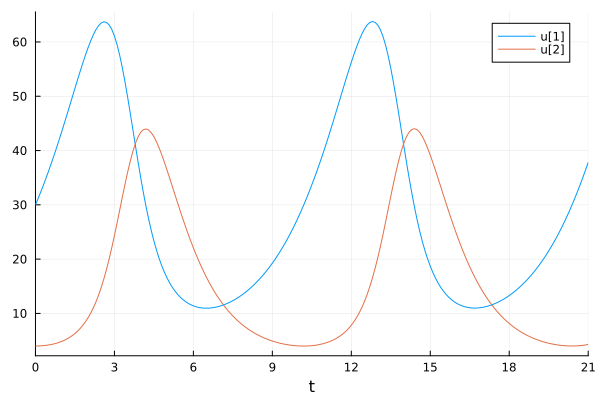

In [14]:
# Define Lotka-Volterra model. u[1] = Hare, u[2] = Lynx
function lotka_volterra(du, u, p, t)
    # Model parameters.
    α, β, γ, δ = p
    # Current state.
    x, y = u

    # Evaluate differential equations.
    du[1] = (α - β * y) * x # prey
    du[2] = (δ * x - γ) * y # predator

    return nothing
end

# Define initial-value problem. This is the "truth" we will try to recover
u0 = [30.0, 4.0]
p = [.5,.03,.9,.03]
tspan = (0.0, 21.0)  # 21 years 
prob = ODEProblem(lotka_volterra, u0, tspan, p)
sol = solve(prob, Tsit5(), saveat=0.1)
# Plot simulation.
plot(sol)

We will generate some synthetic data, sampled at each integer which we will take to be 'years'.  

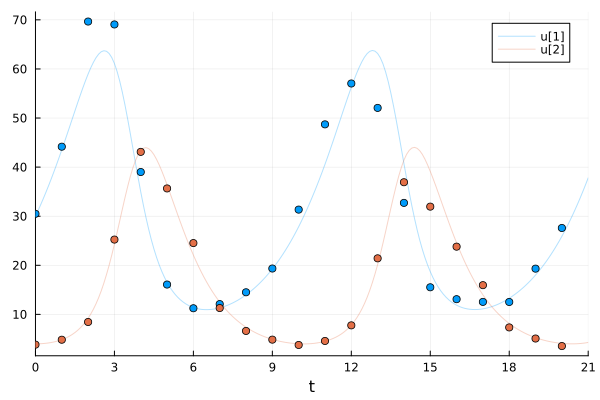

In [17]:
times = collect(range(0, 20))
sol_measure = solve(prob,  TRBDF2(), saveat = times)
# add noise
Random.seed!(14);
odedata = exp.(log.(Array(sol_measure)) + 0.1 * randn(size(Array(sol_measure))))
# Plot simulation and noisy observations.
plot(sol; alpha=0.3)
scatter!(times, odedata'; color=[1 2], label="")

Export odedata for use in sunode version:

In [19]:
#export odedata : 
# using DataFrames, CSV
# df = DataFrame(hare = odedata[1,:], lynx = odedata[2,:], times = times)
# CSV.write("ode_data.csv", df)

"ode_data.csv"

For future runs, read in the data:

In [20]:
using DataFrames, CSV
df = CSV.read("ode_data.csv", DataFrame)
odedata = [df.hare'; df.lynx']
times = df.times;

Define the turing model, using the solver to generate predicted values.

In [22]:
@model function fitlv(data, prob)
    # Prior distributions.
    x0 ~ truncated(Normal(10,50);lower = 0.1, upper = Inf)
    y0 ~ truncated(Normal(10,50);lower = 0.1, upper = Inf)
     
    # Compute the parameters of the ode based on our prior parameters
    α ~ truncated(Normal(.5, 1); lower=0, upper=2)
    β ~ truncated(Normal(.5, 1); lower=0, upper=2)
    γ ~ truncated(Normal(.5, 1); lower=0, upper=2)
    δ ~ truncated(Normal(.5, 1); lower=0, upper=2)
    σ ~ Exponential(1)
 

    # Simulate Lotka-Volterra model. 
    p = [α, β, γ, δ]
    u0 = [x0, y0]
    predicted = solve(prob,  TRBDF2(); u0=u0, p=p, saveat=times)
    
    # Observations with multiplicative noise.
    for i in 1:length(predicted)
        # hacky but it works
        log_pred = log.(max.(predicted[i],0))
        data[:, i] ~ MvLogNormal(log_pred, σ^2 * I)
    end

    return nothing
end

fitlv (generic function with 2 methods)

In [23]:

model = fitlv(odedata, prob)


DynamicPPL.Model{typeof(fitlv), (:data, :prob), (), (), Tuple{Matrix{Float64}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(lotka_volterra), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, SymbolicIndexingInterface.SymbolCache{Nothing, Nothing, Nothing}}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}}, Tuple{}, DynamicPPL.DefaultContext}(fitlv, (data = [30.48697614858022 44.1605855266289 … 19.31809195760856 27.599305130821737; 3.834610056182525 4.837056167500201 … 5.082473200416793 3.5477561323982205], prob = ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(lotka_volterra), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, 

In [24]:

# Sample 4 independent chains with forward-mode automatic differentiation (the default).
chain = sample(model, NUTS(), MCMCSerial(), 1000, 4,progress=false)

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference C:\Users\rjljr\.julia\packages\Turing\tdsVz\src\mcmc\hmc.jl:191


┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference C:\Users\rjljr\.julia\packages\Turing\tdsVz\src\mcmc\hmc.jl:191


┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\rjljr\.julia\packages\Turing\tdsVz\src\mcmc\hmc.jl:191


┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference C:\Users\rjljr\.julia\packages\Turing\tdsVz\src\mcmc\hmc.jl:191


Chains MCMC chain (1000×19×4 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 4
Samples per chain = 1000
Wall duration     = 79.45 seconds
Compute duration  = 76.72 seconds
parameters        = x0, y0, α, β, γ, δ, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

          x0   30.4452    1.0182    0.0202   2571.1655   2511.4140    1.0010   ⋯
          y0    3.9117    0.1346    0.0027   2453.0386   2132.9238    1.0022   ⋯
           α    0.5129    0.0227    0.0007   1220.2869   1671.9538    1.0044   ⋯
           β    0.0316    0.0019    0.0001   1345.8321   1968.1551    1.0034   ⋯
           γ    0.8974    0.0375    0.0011   1143.0

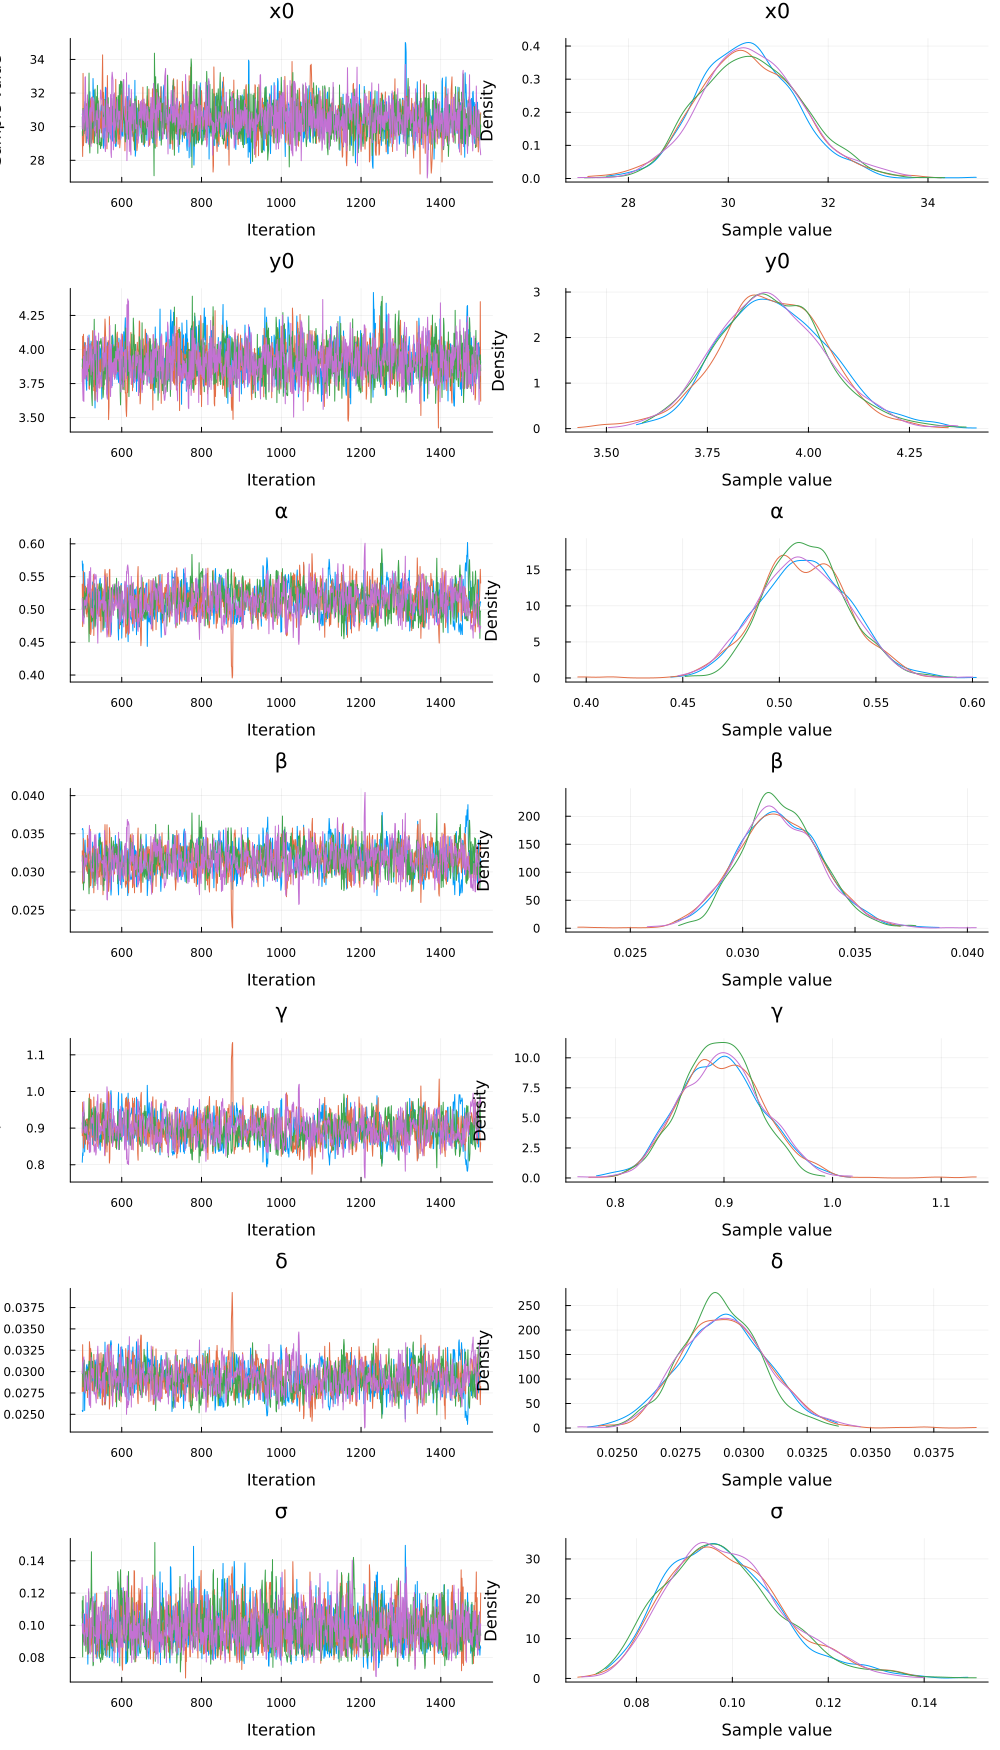

In [25]:
plot(chain)

Generate posterior predictive plots of the solutions to the differential equations using samples from the posterior:

In [27]:
posterior_samples = sample(chain[[:x0,:y0,:α, :β, :γ, :δ]], 300; replace=false);

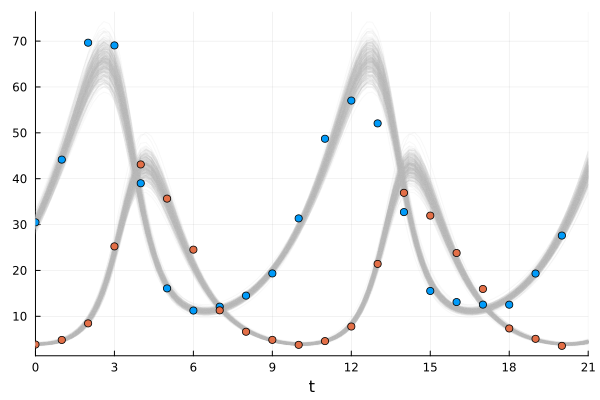

In [28]:
plot(; legend=false)
posterior_samples = sample(chain[[:x0,:y0,:α, :β, :γ, :δ]], 300; replace=false)
for row in eachrow(Array(posterior_samples))
    u0 = row[1:2]
    p = row[3:end]
    sol_p = solve(prob, Tsit5();u0=u0, p=p, saveat=0.2)
    plot!(sol_p; alpha=0.1, color="#BBBBBB")
end

# Plot simulation and noisy observations.
#plot!(sol; color=[1 2], linewidth=1)
scatter!(times, odedata'; color=[1 2])